<a href="https://colab.research.google.com/github/wongalvis14/ReinforcementLearning_Examples/blob/master/number_game_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from matplotlib import pyplot as plt

Game works as:

1. Dealer draws a number, only revealing to himself
2. Makes a market of bet from 0 - 2 (0 means no bet / give up)
3. Player decides whether to make that bet
4. Dealer draws another number, if the first number is larger, takes player's bet, if draw, both take back their bets, otherwise pays player

Findings:

1. RL policy resolves to making value-bets, since the player agents are more or less completely random
2. Value-bet player reduces dealer gains

In [0]:
low = 0
high = 5

max_bet = 2
min_bet = 0

In [0]:
def initialize_q(max_bluff, num_range=high-low+1, bet_range=max_bet-min_bet+1):
    return np.zeros((max_bluff + 1, num_range, bet_range))

In [0]:
def get_number(low=low, high=high):
    return np.random.randint(low, high+1)

In [0]:
class random_gambler_agent:
    def __init__(self, bet_rate = 0.5):
        self.bet_rate = bet_rate
    def gamble(self, bet):
        if np.random.rand() <= self.bet_rate:
            return 1
        return 0

In [0]:
class random_value_gambler_agent:
    def __init__(self, bet_rate = 0.2):
        self.bet_rate = bet_rate
    def gamble(self, bet):
        if np.random.rand() <= self.bet_rate:
            return 1
        if bet < (max_bet - min_bet)/2:
            return 1
        return 0

In [0]:
gambler_agent = random_gambler_agent()

In [0]:
def get_reward(num, num2, bet):
    gamble = gambler_agent.gamble(bet)
    if gamble == 0:
        return 0
    if num > num2:
        return bet
    if num == num2:
        return 0
    return -1 * bet

In [0]:
def is_bluff(num, bet):
    return ((bet - min_bet) / (max_bet - min_bet)) > ((num - low) / (high - low))

In [0]:
class dealer_agent:

    def __init__(self, gamma=0.3, learning_rate = 0.2, explore_p = 0.25, max_bluff = 3):
        self.bluff = 1
        self.max_bluff = max_bluff
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.explore_p = explore_p
        self.q_table = initialize_q(max_bluff = self.max_bluff)
        self.last_total = 0
        self.totals = []
        print ("New bet agent created\n")
    
    def make_bet(self, num, explore_p):
        if np.random.rand() <= explore_p:
            bet = min_bet + np.random.choice(max_bet - min_bet + 1)
        else:
            bet = min_bet + np.argmax(self.q_table[self.bluff, num])
        if is_bluff(num, bet):
            self.bluff = min(self.bluff + 1, self.max_bluff)
        else:
            self.bluff = max(0, self.bluff - 1)
        return bet
    
    def play_round(self, num, bet):
        num2 = get_number()
        reward = get_reward(num, num2, bet)
        return reward

    def get_next_rewards(self):
        q = self.q_table[self.bluff]
        bluff_reward = 0
        value_reward = 0
        for num in range(low, high + 1):
            num_bluff_reward = 0
            num_value_reward = 0
            for bet in range(min_bet, max_bet + 1):
                if is_bluff(bet, num):
                    num_bluff_reward = max(num_bluff_reward, q[num, bet])
                else:
                    num_value_reward = max(num_value_reward, q[num, bet])
            bluff_reward += num_bluff_reward
            value_reward += num_value_reward
        return (bluff_reward / (high - low + 1), value_reward / (high - low + 1))

    def get_q_table(self):
        return self.q_table

    def reset_policy(self):
        self.q_table = initialize_q(max_bluff = self.max_bluff)

    def train(self, episodes=1000, print_every=50, verbose=False, reset=True):
        if reset:
            self.q_table = initialize_q(self.max_bluff)
            self.bluff = 1
            total = 0
            self.totals = []
        else:
            total = self.last_total

        for episode in range(1,episodes + 1):
            num = get_number()
            cur_bluff = self.bluff

            bet = self.make_bet(num, self.explore_p)
            reward = self.play_round(num, bet)
            if verbose:
                print('num {} bet {} reward {} bluff {}'.format(num, bet,reward, cur_bluff))
            (next_reward_bluff, next_reward_value) = self.get_next_rewards()
            next_reward = max(next_reward_bluff, next_reward_value)

            self.q_table[cur_bluff, num, bet] = self.q_table[cur_bluff, num, bet] + self.learning_rate * (reward + self.gamma * next_reward - self.q_table[cur_bluff, num, bet])
            total = total + reward
            self.totals.append(total)
            if episode % print_every == 0:
                print('Episode {} Total Reward: {}'.format(episode,total))

        self.last_total = total


In [0]:
agent = dealer_agent()

New bet agent created



In [0]:
agent.train(episodes = 10000000, print_every = 500000)

Episode 500000 Total Reward: 64841
Episode 1000000 Total Reward: 130717
Episode 1500000 Total Reward: 196356
Episode 2000000 Total Reward: 263333
Episode 2500000 Total Reward: 329395
Episode 3000000 Total Reward: 395768
Episode 3500000 Total Reward: 462413
Episode 4000000 Total Reward: 528471
Episode 4500000 Total Reward: 594867
Episode 5000000 Total Reward: 659945
Episode 5500000 Total Reward: 725504
Episode 6000000 Total Reward: 791559
Episode 6500000 Total Reward: 856991
Episode 7000000 Total Reward: 923082
Episode 7500000 Total Reward: 989998
Episode 8000000 Total Reward: 1055893
Episode 8500000 Total Reward: 1121961
Episode 9000000 Total Reward: 1187133
Episode 9500000 Total Reward: 1252823
Episode 10000000 Total Reward: 1317611


In [0]:
agent.q_table

array([[[ 0.06631035, -0.27814446, -0.39714408],
        [ 0.06036289, -0.05241168, -0.3294353 ],
        [ 0.06305997, -0.17755877,  0.4199815 ],
        [ 0.0641747 , -0.02916336, -0.02105759],
        [ 0.08409383,  0.33607393,  0.04729757],
        [ 0.10609347,  0.49359386,  0.3812229 ]],

       [[ 0.09672223, -0.41685827, -0.88420773],
        [ 0.07298205, -0.32170885, -0.01853727],
        [ 0.09215049, -0.01330833, -0.34445186],
        [ 0.10240547, -0.00972081, -0.45456302],
        [ 0.09443349,  0.27668022,  0.07974765],
        [ 0.09799113,  0.45769728,  1.01713711]],

       [[ 0.08384127, -0.51006156, -1.14432091],
        [ 0.08151846, -0.12845828, -0.13975775],
        [ 0.07741489,  0.04252949, -0.17059917],
        [ 0.09075491,  0.40965027, -0.06440097],
        [ 0.08992618,  0.30239127,  0.30332603],
        [ 0.10962579,  0.4718748 ,  0.39956543]],

       [[ 0.08877639, -0.08234417, -0.55989922],
        [ 0.09242741, -0.29677341, -0.69716974],
        [ 0.07

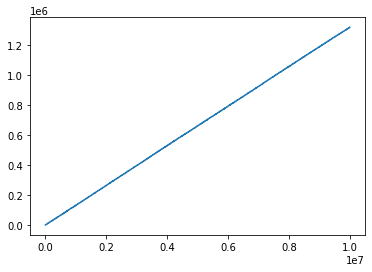

In [0]:
plt.plot(agent.totals) 
plt.show()

In [0]:
gambler_agent = random_value_gambler_agent()

In [0]:
agent.train(episodes = 10000000, print_every = 500000)

Episode 500000 Total Reward: 21835
Episode 1000000 Total Reward: 43553
Episode 1500000 Total Reward: 65165
Episode 2000000 Total Reward: 86728
Episode 2500000 Total Reward: 109039
Episode 3000000 Total Reward: 131228
Episode 3500000 Total Reward: 153686
Episode 4000000 Total Reward: 176103
Episode 4500000 Total Reward: 198596
Episode 5000000 Total Reward: 220674
Episode 5500000 Total Reward: 242120
Episode 6000000 Total Reward: 264112
Episode 6500000 Total Reward: 286730
Episode 7000000 Total Reward: 308631
Episode 7500000 Total Reward: 331495
Episode 8000000 Total Reward: 354316
Episode 8500000 Total Reward: 376466
Episode 9000000 Total Reward: 398570
Episode 9500000 Total Reward: 420796
Episode 10000000 Total Reward: 443057


In [0]:
agent.q_table

array([[[ 0.02308835, -0.20494678, -0.07677218],
        [ 0.02944012, -0.01869321, -0.18023923],
        [ 0.02753667, -0.14712756,  0.00668601],
        [ 0.03514257, -0.11476094, -0.52133741],
        [ 0.01541312,  0.20974016, -0.39988471],
        [ 0.01609131,  0.1810774 ,  0.17037459]],

       [[ 0.04082474, -0.26901219,  0.00954181],
        [ 0.02303062, -0.02359083, -0.05263524],
        [ 0.0213212 , -0.04609869, -0.07922541],
        [ 0.01973047,  0.00977265,  0.0141549 ],
        [ 0.01699637,  0.1258098 , -0.27775432],
        [ 0.02923018,  0.14177125,  0.10767888]],

       [[ 0.03447207, -0.24107362, -0.20729237],
        [ 0.02912075, -0.14560011, -0.26409099],
        [ 0.03117524, -0.08866492, -0.15642114],
        [ 0.03772821,  0.09858638,  0.03234488],
        [ 0.03939286,  0.06325749, -0.13814863],
        [ 0.05080266,  0.28399832,  0.08521131]],

       [[ 0.02977443, -0.39245453, -0.23450611],
        [ 0.024844  , -0.14156548, -0.07113235],
        [ 0.02

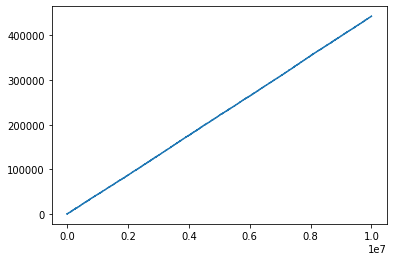

In [0]:
plt.plot(agent.totals) 
plt.show()